# Comparing Dense vs. SVD Retrieval
**Author:** Hai Ran Zheng

**Date:** March 14th, 2025

**Description:** 
Compare train time, inference time, and quality of SVD and Dense Embedding Retrieval

# Imports

In [174]:
import pandas as pd
import numpy as np
import re
import os
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import nltk
from typing import Literal, Union
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# check to see if the nltk data has been downloaded in the virtual environment
if not os.path.exists(os.path.join(os.path.expanduser("~"), "nltk_data")):
    # download the nltk data
    nltk.download('stopwords')
    nltk.download('punkt_tab')
    
from helpers import (
    generate_word_frequencies_from_column
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Utilities/Setup

In [175]:
def left_align(df: pd.DataFrame):
    '''
        Apply left text-align 
    '''
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

In [176]:
%load_ext autoreload
%autoreload 2 
## Every time import python package, refresh function definitions if there has been changes.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
pd.set_option('max_colwidth', 400)

In [178]:
# Matplotlib custom config
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.alpha"] = "0.2"
plt.rcParams["grid.linestyle"] = "-."

# Setup Dataset

In [179]:
PARENT_DIR = os.getcwd().rsplit(os.sep, maxsplit=1)[0]
DATASET_DIR = os.path.join(PARENT_DIR, "Datasets")

In [180]:
rand_path = f"{DATASET_DIR}/complaints_and_recalls.csv"

In [181]:
df = pd.read_csv(f"{DATASET_DIR}/complaints_and_recalls.csv")

In [182]:
df["IS_COMPLAINT"].value_counts()

IS_COMPLAINT
False    25681
True     11615
Name: count, dtype: int64

## EDA

Explore words found in recall but not in complaints, and words found in complaints but not in recall, or words found in both. This can help determine which words to remove from IR system, as well as logistic regression.

In [183]:
all_freq = generate_word_frequencies_from_column(
    df, "CDESCR"
)

In [184]:
complaint_word_freq = generate_word_frequencies_from_column(
    df[df["IS_COMPLAINT"] == 1], "CDESCR"
)

In [185]:
recall_word_freq = generate_word_frequencies_from_column(
    df[df["IS_COMPLAINT"] == 0], "CDESCR"
)

In [186]:
len(all_freq)

34261

### Intersect

In [187]:
dataset_intersect = pd.Series(
    np.intersect1d(recall_word_freq.index, complaint_word_freq.index)
)

In [188]:
all_intersect_freqs = all_freq[all_freq.index.isin(dataset_intersect)]

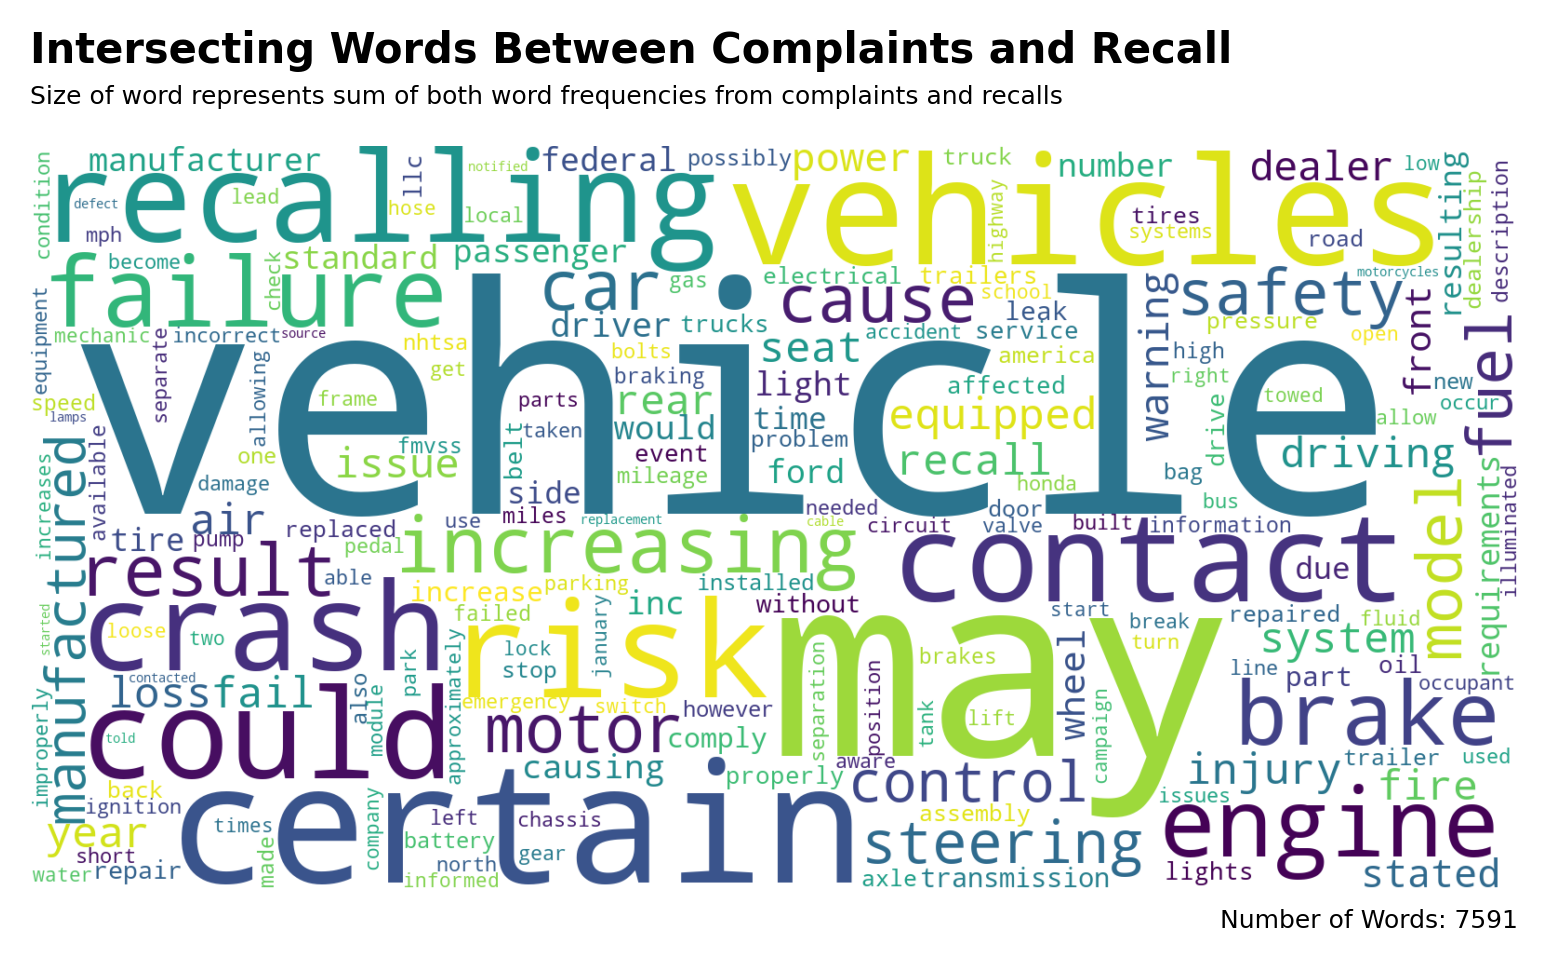

In [189]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(all_intersect_freqs.to_dict()['count'])
plt.figure(dpi=300)
ax = plt.gca()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.suptitle('Intersecting Words Between Complaints and Recall', x=0, y=1.1, va="bottom",
                 ha="left", fontsize=10, fontweight=900, transform=ax.transAxes)
_ = plt.title("Size of word represents sum of both word frequencies from complaints and recalls", 
              x=0, y=1.05, ha="left", va="bottom", fontsize=6, transform=ax.transAxes)
_ = plt.text(s=f"Number of Words: {len(dataset_intersect)}", x=1, y=-0.05, ha="right", transform=ax.transAxes,
         fontsize=6)

Top difference in frequency for intersecting words

In [190]:
complaint_intersect_freqs = complaint_word_freq[
    complaint_word_freq.index.isin(dataset_intersect)
]

In [191]:
recall_intersection_freqs = recall_word_freq[
    recall_word_freq.index.isin(dataset_intersect)
]

In [192]:
compare_intersect_freqs = pd.merge(
    complaint_intersect_freqs,
    recall_intersection_freqs,
    left_index=True,
    right_index=True,
    suffixes=("_complaint", "_recall")
)

In [193]:
compare_intersect_freqs

,count_complaint,count_recall
CDESCR,,
vehicle,17821,19342
contact,13077,1589
failure,8940,2695
car,7988,403
engine,7045,4346
...,...,...
thompson,1,2
5f,1,1
corrodes,1,15


### Largest Word Count Difference where there are more complaint than recall

In [194]:
compare_intersect_freqs["more_complaint_than_recall"] = (
    compare_intersect_freqs["count_complaint"] - compare_intersect_freqs["count_recall"]
)
complaint_more_than_recall = compare_intersect_freqs[
    compare_intersect_freqs["more_complaint_than_recall"] >= 0
]

In [195]:
complaint_more_than_recall["more_complaint_than_recall"].sort_values(ascending=False).head(10)

CDESCR
contact         11488
car              7585
failure          6245
dealer           5646
issue            5640
stated           5284
recall           5190
driving          4282
manufacturer     4222
repair           3075
Name: more_complaint_than_recall, dtype: int64

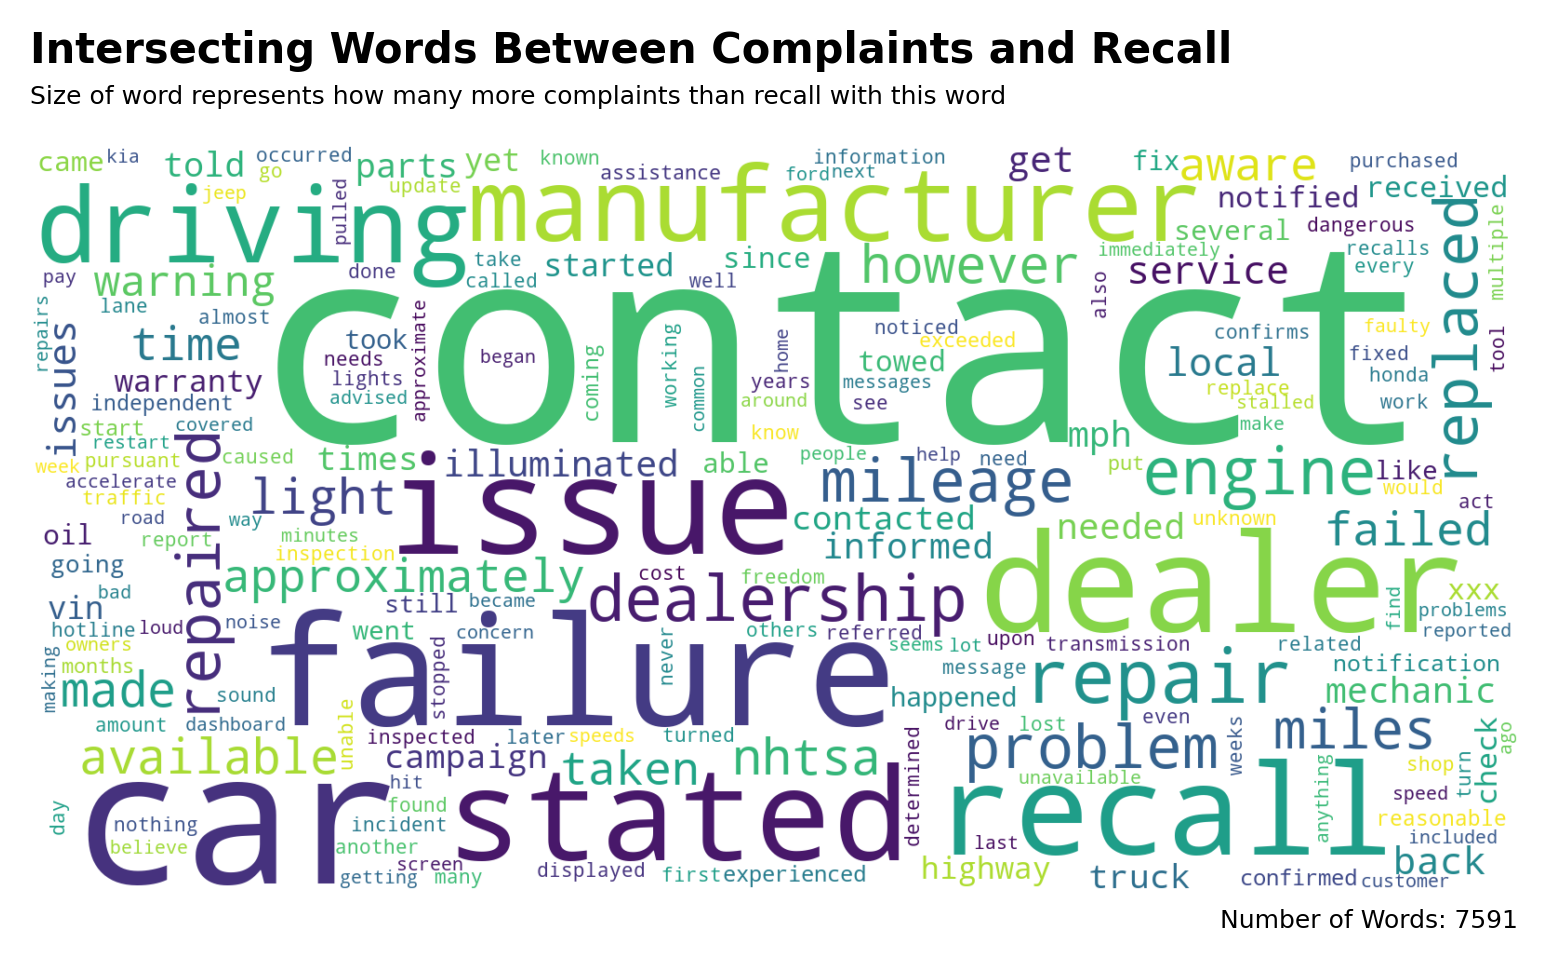

In [196]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(
                    complaint_more_than_recall.to_dict()["more_complaint_than_recall"]
    
                )
plt.figure(dpi=300)
ax = plt.gca()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.suptitle('Intersecting Words Between Complaints and Recall', x=0, y=1.1, va="bottom",
                 ha="left", fontsize=10, fontweight=900, transform=ax.transAxes)
_ = plt.title("Size of word represents how many more complaints than recall with this word", 
              x=0, y=1.05, ha="left", va="bottom", fontsize=6, transform=ax.transAxes)
_ = plt.text(s=f"Number of Words: {len(dataset_intersect)}", x=1, y=-0.05, ha="right", transform=ax.transAxes,
         fontsize=6)

In [197]:
compare_intersect_freqs["more_recall_than_complaint"] = (
    compare_intersect_freqs["count_recall"] - compare_intersect_freqs["count_complaint"]
)
recall_more_than_complaint = compare_intersect_freqs[
    compare_intersect_freqs["more_recall_than_complaint"] >= 0
]

In [198]:
recall_more_than_complaint["more_recall_than_complaint"].sort_values(ascending=False).head(10)

CDESCR
may           28913
certain       19260
vehicles      15588
recalling     14896
crash         14076
risk          13903
could         10709
increasing     9139
result         8076
motor          7096
Name: more_recall_than_complaint, dtype: int64

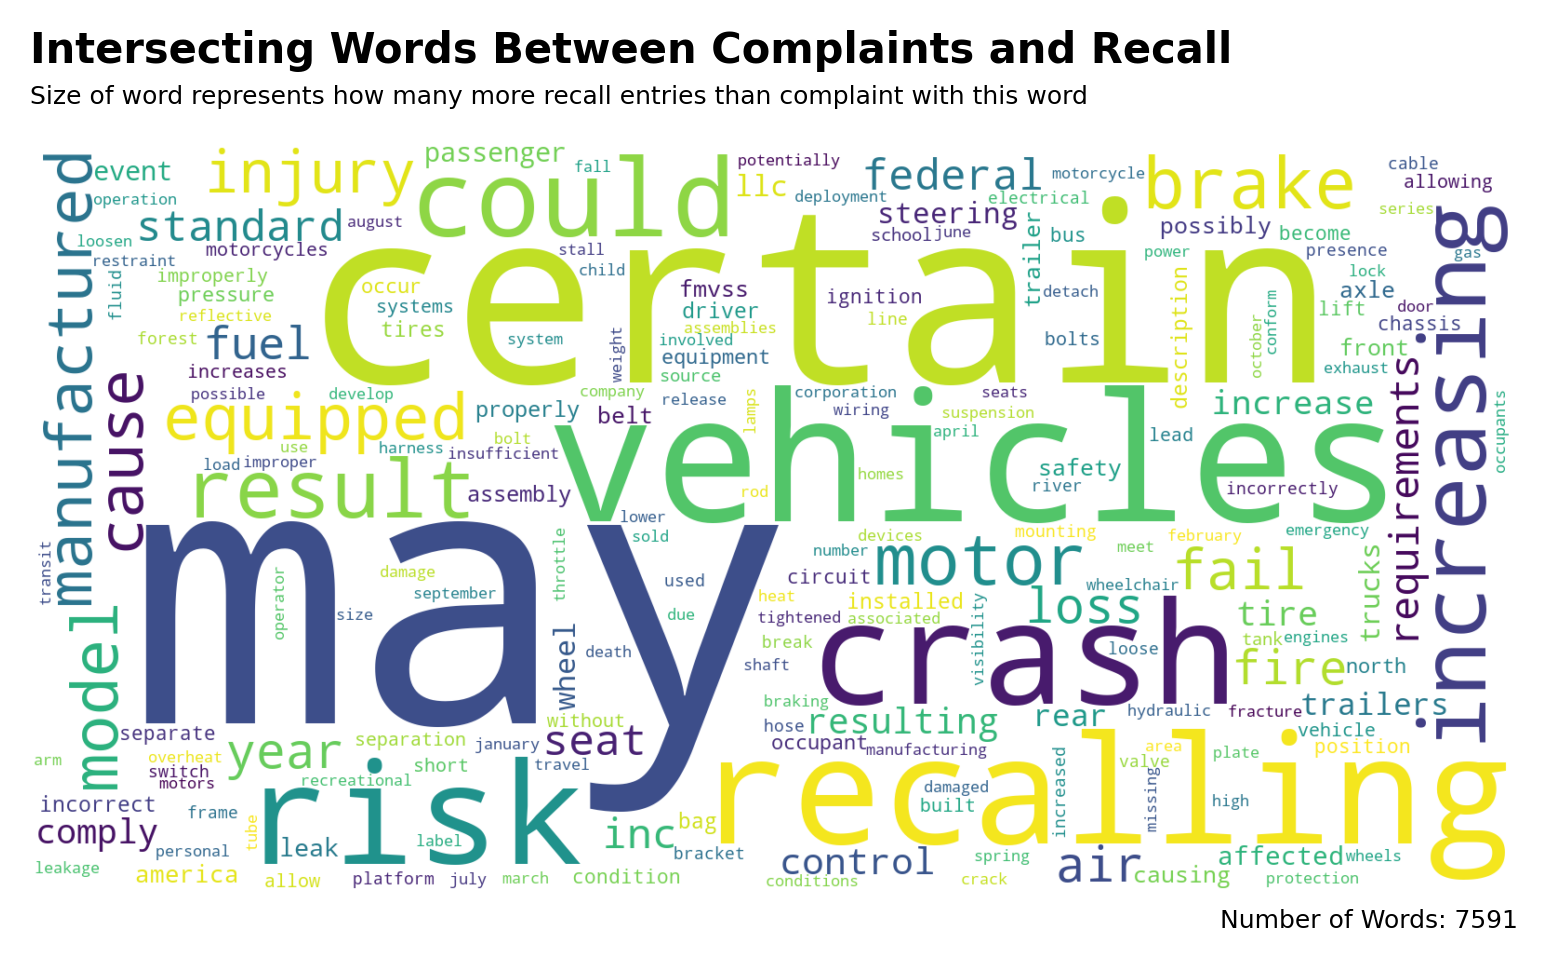

In [199]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(
                    recall_more_than_complaint.to_dict()["more_recall_than_complaint"]
    
                )
plt.figure(dpi=300)
ax = plt.gca()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.suptitle('Intersecting Words Between Complaints and Recall', x=0, y=1.1, va="bottom",
                 ha="left", fontsize=10, fontweight=900, transform=ax.transAxes)
_ = plt.title("Size of word represents how many more recall entries than complaint with this word", 
              x=0, y=1.05, ha="left", va="bottom", fontsize=6, transform=ax.transAxes)
_ = plt.text(s=f"Number of Words: {len(dataset_intersect)}", x=1, y=-0.05, ha="right", transform=ax.transAxes,
         fontsize=6)

### Difference

In [200]:
words_complaint = set(complaint_word_freq.index.tolist())
words_recall = set(recall_word_freq.index.tolist())

# Words only in complaint
unique_complaint = words_complaint - words_recall

In [201]:
complaint_diff = all_freq[all_freq.index.isin(unique_complaint)]

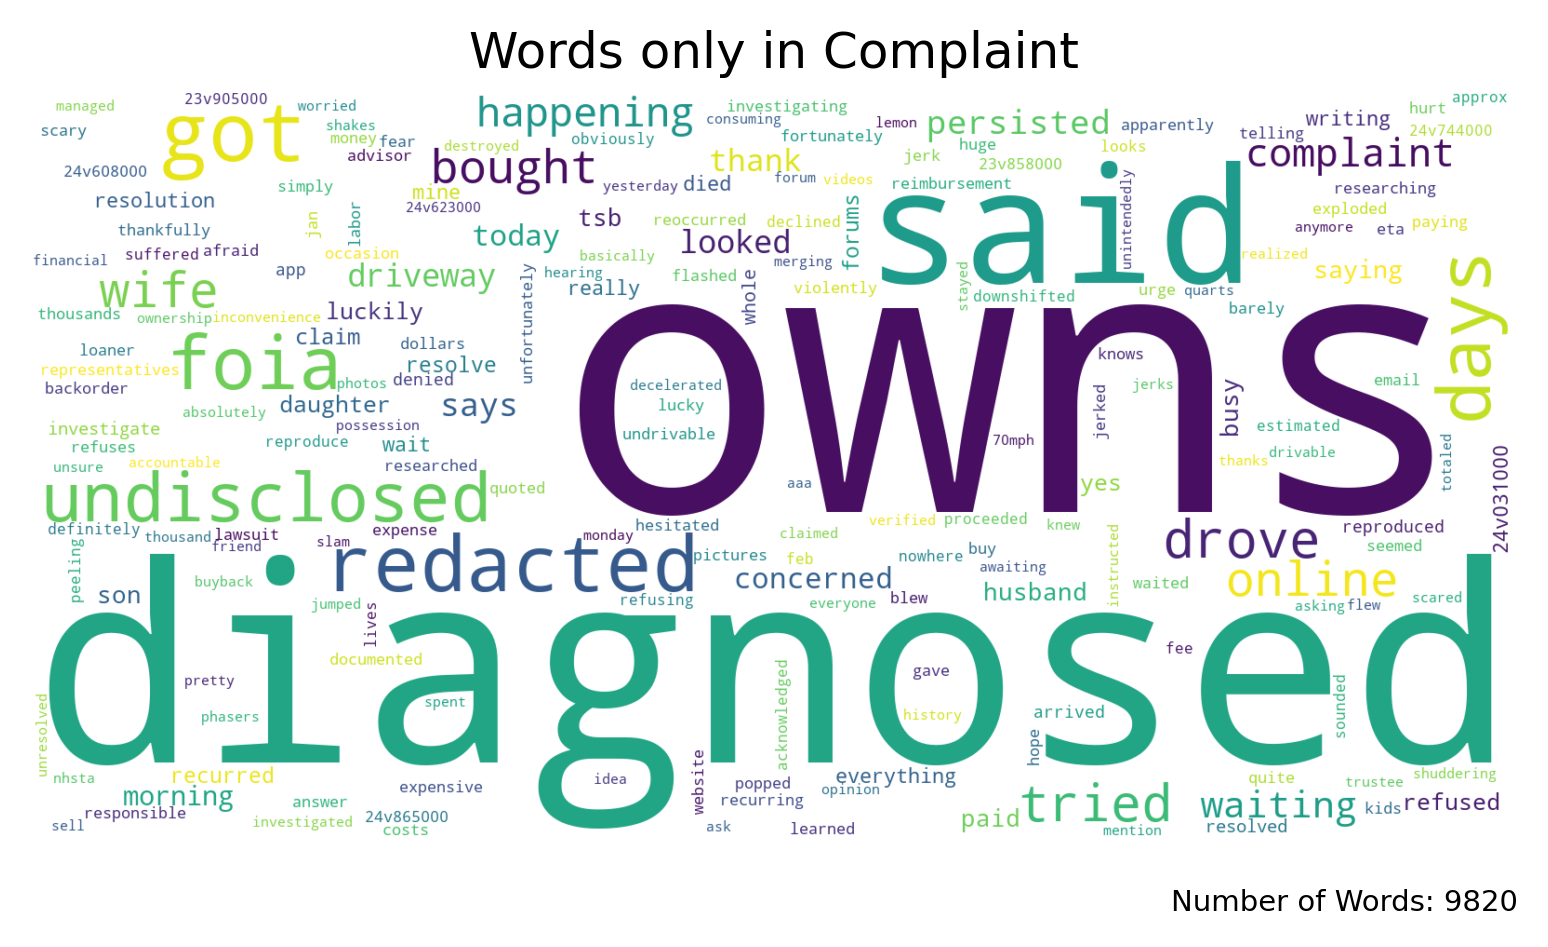

In [202]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(complaint_diff.to_dict()['count'])
plt.figure(dpi=300)
ax = plt.gca()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.text(s=f"Number of Words: {len(complaint_diff)}", x=1, y=-0.1, ha="right", transform=ax.transAxes,
         fontsize=7)
plt.margins(x=0, y=0)
_ = plt.title('Words only in Complaint')

In [203]:
words_complaint = set(complaint_word_freq.index.tolist())
words_recall = set(recall_word_freq.index.tolist())

# Words only in recall
unique_recall = words_recall - words_complaint

In [204]:
recall_diff = all_freq[all_freq.index.isin(unique_recall)]

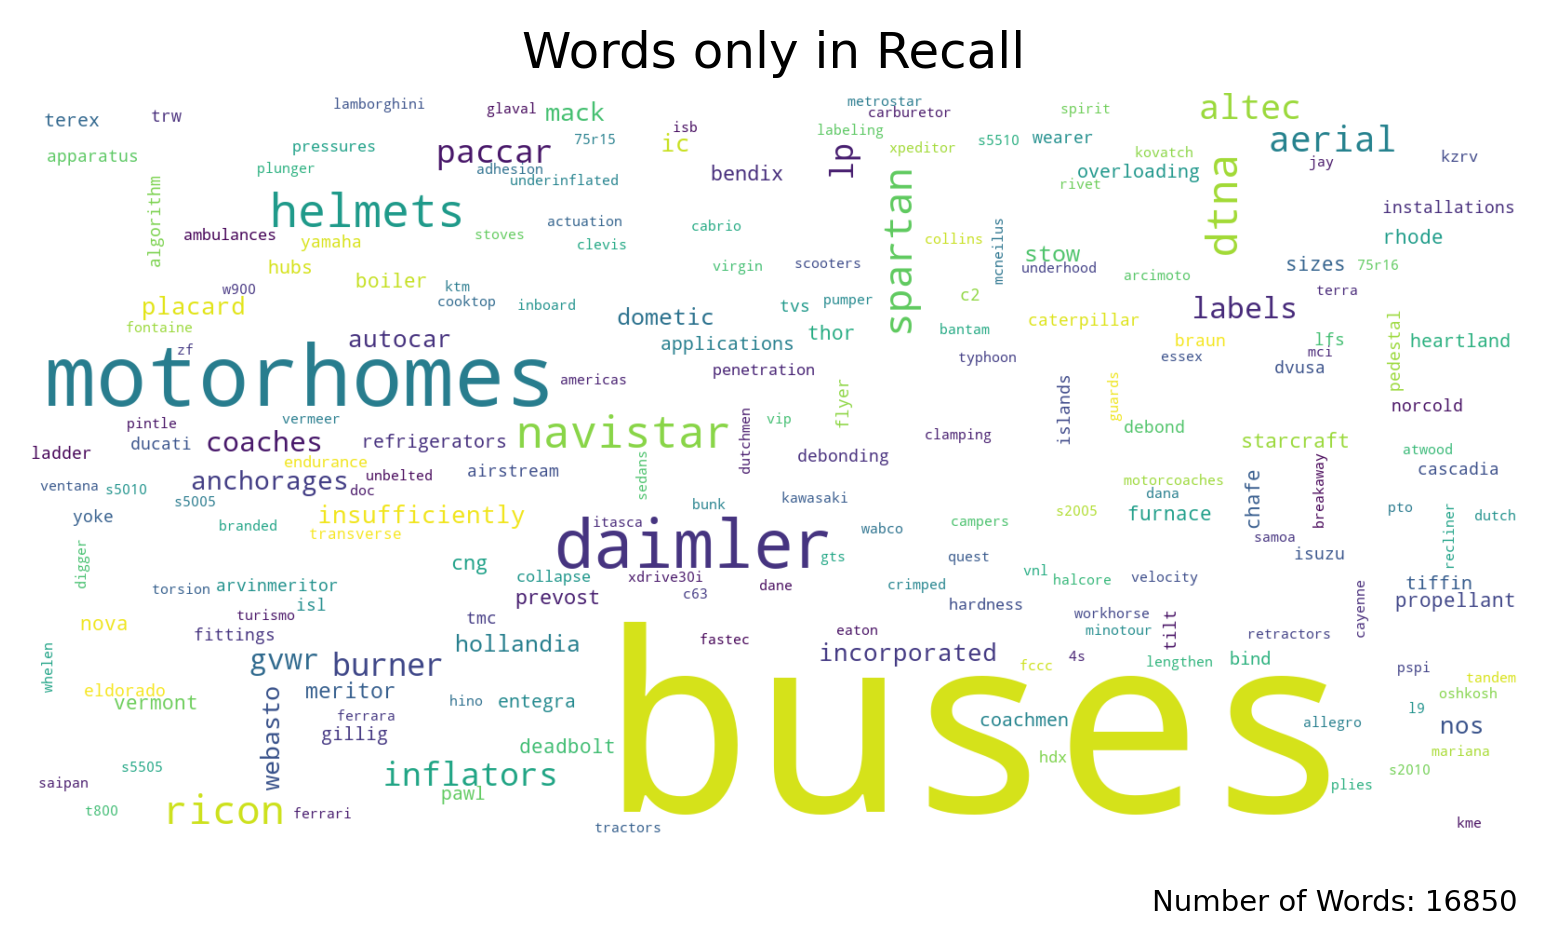

In [205]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(recall_diff.to_dict()['count'])
plt.figure(dpi=300)
ax = plt.gca()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.text(s=f"Number of Words: {len(recall_diff)}", x=1, y=-0.1, ha="right", transform=ax.transAxes,
         fontsize=7)
plt.margins(x=0, y=0)
_ = plt.title('Words only in Recall')

# List of Queries For Testing
<div style="font-size:20px;font-weight:700">
    Direct Vehicle Issues
</div>

- Speaker rattles
- Clicking sound steering left and right
- Brake lamps stay on
- Air bag issues from faulty sensor
- Bad smell can be observed due to break pads overheating.
- Overheating can be observed due to power train issues.
- Door open/close issues can be observed due to door latch issue, child safety mode malfunctions.
- Harsh clutch movements can be observed due to transmission/powertrain issues.
- Steering wheel issues can be observed due to unbalanced tires.
- Seat adjustment issues can be observed due to debri in seat latch.
- Light issues can be observed due to faulty electrical sensors.

 - **Latch** is an interesting one, as well as **axle**, since it could refer to different parts of a vehicle.


# SVD Retrieval

1. Convert Documents into TF-IDF vector
2. Train Scikit-Learn's SVD algorithm on train set
3. Retrieve relevant documents given query
4. Show relevant topics

In [206]:
clf_svd = TextClassifier(f'{DATASET_DIR}/complaints_and_recalls.csv', column_name='CDESCR',n_dimensions=384)

NameError: name 'TextClassifier' is not defined

In [12]:
_ = clf_svd.run_training_pipeline(subgroup="SVD_384")

In [13]:
len(clf_svd.df_train)

26444

## Training Time

2 minute 10 second training time for 26444 documents. That's about 26644/130 = 205 documents per second on my computer. Here are my computer specs:

In [14]:
!cpuinfo

Python Version: 3.12.7.final.0 (64 bit)
Cpuinfo Version: 9.0.0
Vendor ID Raw: AuthenticAMD
Hardware Raw: 
Brand Raw: AMD Ryzen 5 8640HS w/ Radeon 760M Graphics
Hz Advertised Friendly: 3.4930 GHz
Hz Actual Friendly: 3.5010 GHz
Hz Advertised: (3493000000, 0)
Hz Actual: (3501000000, 0)
Arch: X86_64
Bits: 64
Count: 12
Arch String Raw: AMD64
L1 Data Cache Size: 
L1 Instruction Cache Size: 
L2 Cache Size: 6291456
L2 Cache Line Size: 1024
L2 Cache Associativity: 6
L3 Cache Size: 16777216
Stepping: 2
Model: 117
Family: 25
Processor Type: 
Flags: 3dnow, 3dnowext, 3dnowprefetch, abm, adx, aes, apic, avx, avx2, avx512bitalg, avx512bw, avx512cd, avx512dq, avx512f, avx512ifma, avx512vbmi, avx512vbmi2, avx512vl, avx512vnni, avx512vpopcntdq, bmi1, bmi2, clflush, clflushopt, clwb, cmov, cmp_legacy, cr8_legacy, cx16, cx8, de, dts, erms, f16c, fma, fpu, fxsr, gfni, ht, hypervisor, ia64, invpcid, lahf_lm, mca, mce, misalignsse, mmx, monitor, movbe, msr, mtrr, osvw, osxsave, pae, pat, pclmulqdq, perfctr_c

Ignore python version as it is my global python version. I'm using a venv that has a different python version (3.10.16)

## Inference Time + Quality of Retrieval

In [15]:
columns_to_inspect = ["CDESCR", "cosine_similarities", "IS_COMPLAINT"]

In [16]:
similar_elements = clf_svd.find_similar(
    query_text="Speaker rattles",
    dataset_to_check="train",
    top=50
)

C:\Users\harri\AppData\Local\Temp\ipykernel_55652\3269253326.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_similar_elements["cosine_similarities"] = cosine_similarities_query.squeeze()[most_similar_indices_query]


In [17]:
c_descr = left_align(similar_elements[columns_to_inspect].head(10))

In [18]:
pd.set_option('max_colwidth', 400)

In [19]:
c_descr

,CDESCR,cosine_similarities,IS_COMPLAINT
1094,Car radio goes so loud it damaged my ear nerves. This results in pain especially when exposed to loud sounds,0.498306,True
9664,"There has been a problem going on with my 2016 Honda Accord Touring and it’s unbelievably terrible it has something to do with the sound system in the car and it can’t be stopped even if you try to power off the Radio it still occurs and it’s an on going problem until the vehicle is powered off, basically it’s a static noise that comes through all speakers that starts off not too loud then it gets really loud! To where you can’t even hear the person in the passenger seat and it is so bad it can possibly cause hearing damage and also to mention you can’t hear any sirens of like an ambulance for instance it happened to me other day where an ambulance was behind me and I didn’t hear it because of the horrible static sound coming from the speakers I found out the ambulance was behind me because of the cars in front of me pulling over to the side of the road and also I have little cousins and I would to go on trips with them but it worries me I can hurt their ears and they might start to panic to how bad the sound is.",0.482936,True
5618,Tapping noise coming from 5.0 engine from cold start. Ford dealership concluded it was a Cam Phasers that needed to be replaced,0.467023,True
1620,During cold starts there is a loud ticking sound coming from the top side of the engine. It appears to be one or more HLA.,0.464828,True
10259,Upon a cold start my vehicle was making a rattling and ticking sound and the car would shake. There were no engine failure or warning lights that came on but the engine did not sound like it was running properly and clearly something was wrong. I took the vehicle in and was told that the Variable Cam Timing parts need to be replaced. In doing some research it appears that the VCT on the 2019 Navigator has a recall for the VCT but my VIN was not included on the recall for some reason.,0.455588,True
3435,In December the vehicle started showing a pedestrian warning sound fault light. The pedestrian warning sound was replaced by a siren that sounds like an air raid siren which makes the car virtually undriveable.,0.446464,True
3763,Loud noise like bomb went off when started vehicle then static in radio speakers wouldn’t stop. I have a 2022 ford f150 lariat with B&O unleashed speakers. Lots of complaints and told to report this issue. Radio came on next day but scared it will happen again.,0.432215,True
782,"At around 75K miles, the CVT transmission started to give an issue. At highway speeds, a whining sound is noticeable inside the cabin. I took the CHR to a local shop for a diagnostic. They identified the CVT as the cause of the noise. At this point, the noise is the only indicator of CVT failure.",0.429937,True
5827,The audio system has become inoperable and instead the speakers are blasting static noise with crackling and popping sounds at high volume. Cannot stop it or use any other audio. Very unsafe to drive due to extreme noise level and lack of controls. Appears many people have this issue and there needs to be a recall to fix.,0.421825,True
9650,"There appears to be a model-wide problem with 2017 Honda Accord audio system that manifests in screeching static noise through audio speakers (whether the radio is turned on or not) at decibels in excess of 100 (sounds like a lawnmower being operated inside a closed 4 door sedan). This noise comes with no warning (or waring lights) and shocks the senses that can cause erratic vehicle operation. Once the noise starts, it will last varying lengths of time that include in excess of 12 minutes. The only means to make it stop is by turning off the car, which is not easy or safe if highway driving. The screeching is so loud, it is impossible to hear emergency sirens or honking horns, making this a serious safety issue. This is also very distracting -- imagine a passenger screaming in your ear as loud

In [22]:
similar_elements = clf_svd.find_similar(
    query_text="Clicking sounds steering left and right",
    dataset_to_check="train",
    top=50
)

C:\Users\harri\AppData\Local\Temp\ipykernel_37020\578085221.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_similar_elements["cosine_similarities"] = cosine_similarities_query.squeeze()[most_similar_indices_query]


In [ ]:
c_descr = left_align(similar_elements[columns_to_inspect].head(10))

In [24]:
c_descr

,CDESCR,cosine_similarities,IS_COMPLAINT
5508,Steering column makes a clicking sound when steering wheel is turned right or left.,0.800408,True
11171,While driving the steering felt stiff to turn left or right and i would hear what sounds like a screech.,0.785178,True
10940,When turning right or left and accelerating there is a loud clicking sound as if the CV joints are bad.,0.710997,True
9684,There is a clicking sound in the axel when making a sharp left turn.,0.690189,True
9567,The vehicle makes a knocking sound when turning - left or right. It seems to be an axle problem.,0.688672,True
1216,Clicking sound when making a right turn,0.682027,True
10944,When turning sharply right and left a knocking sound occurs when accelerating. I have reproduced the sound multiple times. Service department confirms the CV joint is failing.,0.681949,True
3758,Loud clicking from left side of the vehicle when making a right hand turn.,0.673695,True
9707,"There is a loud, audible clicking noise when turning the steering wheel to the left or to the right, regardless of speed.",0.651930,True
3656,Knocking sound when sharp turn to the right. CV Joint?,0.644029,True


In [25]:
similar_elements = clf_svd.find_similar(
    query_text="brake lamp stay on",
    dataset_to_check="train",
    top=50
)

C:\Users\harri\AppData\Local\Temp\ipykernel_37020\578085221.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_similar_elements["cosine_similarities"] = cosine_similarities_query.squeeze()[most_similar_indices_query]


In [28]:
left_align(similar_elements[columns_to_inspect].head(10))

,CDESCR,cosine_similarities,IS_COMPLAINT
14676,"CERTAIN PICKUP TRUCKS MAY EXPERIENCE THE PERMANENT LOSS OF BRAKE LAMP FUNCTION OR BRAKE LAMPS THAT ARE ILLUMINATED AT ALL TIMES. THE CENTER HIGH-MOUNTED STOP LAMP (CHMSL) IS AFFECTED IN BOTH INSTANCES. ALSO, IF EQUIPPED, THE CRUISE CONTROL WILL BECOME INOPERATIVE. ANY TRAILER BRAKE LAMPS WHICH ARE CONNECTED TO THE VEHICLE'S BRAKE LAMP WIRING WILL MIMIC THE VEHICLE'S BRAKE LAMPS WHEN EITHER CONDITION OCCURS. A FOLLOWING DRIVER MAY NOT KNOW WHEN THE BRAKES HAVE BEEN APPLIED, AND A REAR-END CRASH COULD OCCUR WITHOUT PRIOR WARNING. DEALERS WILL REPLACE THE BRAKE LAMP SWITCH ASSEMBLY. THE RECALL BEGAN ON DECEMBER 5, 2006. OWNERS MAY CONTACT CHEVROLET AT 1-800-630-2438; GMC AT 1-866-996-9463 OR ISUZU AT 1-800-255-6727.",0.852984,False
27010,"ON CERTAIN SEDANS AND WAGONS, THE PLASTIC HOUSING IN THE REAR TAIL LAMP ASSEMBLY CAN BECOME DISTORTED IF THE BRAKE LAMPS REMAIN ON FOR AN EXTENDED TIME. THIS CAN CAUSE (1) AN INTERMITTENTLY INOPERATIVE BRAKE/TAIL LAMP BULB OR (2) A SHORT CIRCUIT THAT OPENS A FUSE CAUSING INOPERATIVE BRAKE LAMPS (INCLUDING THE CENTER HIGH-MOUNTED STOP LAMP) OR TAIL LAMPS. A FOLLOWING DRIVER MAY NOT KNOW WHEN THE BRAKES HAVE BEEN APPLIED, AND A REAR-END CRASH COULD OCCUR WITHOUT PRIOR WARNING. DEALERS WILL INSTALL TWO NEW TAIL LAMP REINFORCING SOCKET ADAPTERS AND SOCKETS FREE OF CHARGE. THE RECALL BEGAN ON OCTOBER 17, 2005. OWNERS MAY CONTACT SATURN AT 1-800-972-8876.",0.767540,False
26762,"ON CERTAIN PASSENGER VEHICLES, THE BRAKE LAMP SWITCH MAY MALFUNCTION. IF THIS HAPPENS, THE BRAKE LAMPS COULD BECOME INOPERATIVE; OR THE LAMPS COULD COME ON AND STAY ON, EVEN THOUGH THE VEHICLE IS PARKED. DEALERS WILL INSPECT AND, IF NECESSARY, REPLACE THE BRAKE LAMP SWITCHES. OWNER NOTIFICATION BEGAN SEPTEMBER 26, 2003. OWNERS SHOULD CONTACT VWOA AT 1-800-822-8987.",0.764756,False
31030,"THE ELECTRICAL SWITCH ADJACENT TO THE BRAKE PEDAL WHICH OPERATES THE BRAKE LAMPS MAY FAIL TO OPERATE. THE BRAKE LAMPS MAY FAIL TO WORK WHEN BRAKES ARE APPLIED,INCREASING THE RISK OF REAR-END COLLISION. REPLACE THE BRAKE LAMP SWITCH WITH AN IMPROVED VERSION.",0.763362,False
23522,"MITSUBISHI IS RECALLING 21,493 MY 2007-2008 OUTLANDER VEHICLES EQUIPPED WITH LED TYPE STOP LAMPS AND DISTRIBUTED IN THE UNITED STATES AND PUERTO RICO. THE BRAKE LAMP SWITCH MAY MALFUNCTION AND CAUSE THE STOP LAMPS TO NOT ILLUMINATE DURING BRAKE APPLICATION. THE FAILURE OF THE BRAKE LAMPS TO ILLUMINATE WHEN THE BRAKES ARE APPLIED WILL NOT PROVIDE WARNING TO FOLLOWING TRAFFIC AND COULD RESULT IN A CRASH. DEALERS WILL REPLACE THE STOP LAMP SWITCH. THE RECALL IS EXPECTED TO BEGIN DURING FEBRUARY 2009. OWNERS MAY CONTACT MITSUBISHI AT 1-800-222-0037.",0.758827,False
35798,"VEHICLE DESCRIPTION: PASSENGER VEHICLES. THE BRAKE LAMP SWITCH TERMINALS COULD OVERHEAT. THIS COULD CAUSE EITHER A LOSS OF BRAKE LAMP FUNCTION OR CONTINUOUSLY ILLUMINATED BRAKE LAMPS, INCREASING THE RISK OF A CRASH. DEALERS WILL INSTALL A NEW STOP LAMP EXTENSION HARNESS WITH BRONZE TERMINALS AT THE BRAKE LAMP SWITCH CONNECTOR, AND ALSO INSPECT THE BRAKE LAMP SWITCH FOR SIGNS OF OVERHEATING AND REPLACE, AS REQUIRED. OWNER NOTIFICATION BEGAN MARCH 22, 2001. OWNERS WHO TAKE THEIR VEHICLES TO AN AUTHORIZED DEALER ON AN AGREED UPON SERVICE DATE AND DO NOT RECEIVE THE FREE REMEDY WITHIN A REASONABLE TIME SHOULD CONTACT FORD AT 1-800-392-3673.",0.746380,False
17741,"EQUIPMENT DESCRIPTION: CLEAR TAIL LAMP ASSEMBLIES WHICH WERE NOT MANUFACTURED WITH RED STOP LAMPS, TAILLAMPS, REFLEX REFLECTORS, AND SIDE MARKER LAMPS AS REQUIRED UNDER FEDERAL MOTOR VEHICLE SAFETY STANDARD NO. 108, ""LAMPS, REFLECTIVE DEVICES, AND ASSOCIATED EQUIPMENT."" WITHOUT THE REFLECTIVE MATERIAL IN THE REAR TAIL LAMP, A VEHICLE WITH THESE LAMPS MAY NOT SEEN BY A FOLLOWING MOTORIST, INCREASING THE RISK OF A CRASH. CK MOTORING INTENDS TO NOTIFY THEIR DISTRIBUTORS OF THE NONCOMPLYING LAMPS AND INSTRUCT THEM TO RETURN THE LAMPS FOR REPLACEMENT LAMPS OR REIMBURSHMENT.",0.715413,False
26763,"ON CERTAI

In [32]:
similar_elements = clf_svd.find_similar(
    query_text="air bag",
    dataset_to_check="train",
    top=50
)

C:\Users\harri\AppData\Local\Temp\ipykernel_37020\578085221.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_similar_elements["cosine_similarities"] = cosine_similarities_query.squeeze()[most_similar_indices_query]


In [34]:
similar_elements["IS_COMPLAINT"].value_counts()

IS_COMPLAINT
False    47
True      3
Name: count, dtype: int64

In [35]:
left_align(similar_elements[columns_to_inspect].head(10))

,CDESCR,cosine_similarities,IS_COMPLAINT
27793,"ON CERTAIN VEHICLES, DUE TO IMPROPER ASSEMBLY OF THE AIR BAG INFLATOR, WHICH IS USED IN THE SIDE AIR BAG, THE CURTAIN SHIELD AIR BAG, AND THE KNEE AIR BAG ASSEMBLY, SOME INFLATORS WERE PRODUCED WITH AN INSUFFICIENT AMOUNT OF THE HEATING AGENTS NECESSARY FOR PROPER AIR BAG DEPLOYMENT. IN THIS CONDITION, THE EXPANSION FORCE OF THE GAS MAY BE INSUFFICIENT TO PROPERLY INFLATE THE AIR BAG WHEN THE SRS SYSTEM IS ACTIVATED DURING A CRASH. THIS MAY INCREASE THE RISK OF INJURY TO THE OCCUPANT IN THE INVOLVED SEATING POSITION IN THE EVENT OF A CRASH. DEALERS WILL REPLACE THE SPECIFIC SRS AIR BAG. THE RECALL BEGAN ON APRIL 6, 2006. OWNERS MAY CONTACT TOYOTA AT 1-888-270-9371, SCION AT 1-866-548-1851, OR LEXUS AT 1-800-255-3987.",0.856660,False
35754,VEHICLE DESCRIPTION: PASSENGER VEHICLES. PASSENGER AIR BAGS WERE BUILT WITH SUSPECT ALUMINUM EXTRUSION SECTIONS WHICH MAY NOT RETAIN THE AIR BAG DOOR DURING AN AIR BAG DEPLOYMENT EVENT. A SEPARATED AIR BAG DOOR COULD INJURE A VEHICLE OCCUPANT. DEALERS WILL REPLACE THE PASSENGER SIDE AIR BAG.,0.855882,False
22639,"Key Safety Systems, Inc. (KSS) is recalling certain Driver Frontal Air Bags, model ADI Dual, manufactured May 6, 2007, to January 29, 2016. These air bags may be missing a chemical enhancer required for the second stage deployment, resulting in the second stage deploying improperly in certain crashes. An air bag that inflates improperly increases the risk of injury. KSS will notify the vehicle manufacturers that purchased the affected air bags, and those manufacturers will notify owners and their dealers will replace the air bag module, free of charge. The recall began on April 1 2016. Owners may contact KSS customer service at 1-586-726-3800.",0.840981,False
25215,"Nissan North America, Inc. (INFINITI) is recalling certain 2003 INFINITI FX35, 2006-2008 FX35 and FX45 vehicles that previously received a replacement front passenger air bag assembly under recall number 20V-008. The air bag cushion was folded incorrectly, which could increase internal pressure and tear the air bag cushion during deployment. A tear in the air bag may decrease air bag performance, and increase the risk of injury. INFINITI will notify owners, and dealers will replace the front passenger air bag module, free of charge. The recall began on April 19, 2021. Owners may contact INFINITI customer service at 1-800-662-6200. INFINITI's number for this recall is R20C2.",0.839632,False
22637,"Key Safety Systems, Inc. (DBA Joyson) is recalling certain Curtain Air Bag Inflators, model HPH-A, and part numbers 2546178-AD, 2546179-AD, 2546180-AD, and 2546219-AE. The air bag inflators may have been manufactured with the incorrect amount of compressed gas, which could result in an improper air bag deployment. An air bag that deploys improperly can increase the risk of injury in a crash. Joyson will work with the affected vehicle manufacturers to replace the curtain air bag module, free of charge. Ram owners may contact FCA US, LLC customer service at 1-800-853-1403. Joyson's number for this recall is QN 22774.",0.825587,False
21526,"IF THE AIR BAG COMPUTER IN A SUBJECT VEHICLE EXPERIENCES A MECHANICAL SHOCK (I.E., RAPIDLY MOVING THE FRONT SEAT BACK AGAINST THE STOPS OR A SUDDEN RELEASE OF THE PARKING BRAKE) WITHIN A VERY SHORT TIME AFTER THE ENGINE IS STARTED, THE AIR BAG CAN DEPLOY INADVERTENTLY. UNEXPECTED AIR BAG DEPLOYMENT CAN RESULT IN OCCUPANT INJURY. DEALERS WILL REPAIR THE AIR BAG COMPUTER.",0.825397,False
11959,"AIR BAG INFLATOR CASE WAS INCORRECTLY MACHINED. IN AN ACCIDENT, THE AIR BAG MAY NOT DEPLOY, WHICH COULD RESULT IN INCREASED INJURY TO THE DRIVER. REPLACE AIR BAG INFLATOR UNIT.",0.822736,False
2815,I have read of several air bag recalls. This car has an air bag light that comes on the dash.,0.816937,True
22589,"Karma Automotive LLC (Karma) is recalling certain 2018 Revero vehicles. In the event of a crash, the side curtain/head protection air bags may partially

In [53]:
%%time
similar_elements = clf_svd.find_similar(
    query_text="bad smell in car. Rubber",
    dataset_to_check="train",
    top=50
)

CPU times: total: 125 ms
Wall time: 123 ms


C:\Users\harri\AppData\Local\Temp\ipykernel_37020\578085221.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_similar_elements["cosine_similarities"] = cosine_similarities_query.squeeze()[most_similar_indices_query]


In [37]:
left_align(similar_elements[columns_to_inspect].head(10))

,CDESCR,cosine_similarities,IS_COMPLAINT
2607,I feel there was intentional odometer tampering done on my car,0.644674,True
4718,"On [XXX], with the wife and 3 grandkids in the car, as we made a left turn and were picking up speed suddenly the car downshifted to first gear. This jerked the whole car whipping the necks of everybody in the car and drastically slowed the car. Fortunately, the guy behind me did not rear end me, but almost. This scared us all. The car recovered and we proceeded the 15 miles home but several times the transmission seemed to have trouble finding the right gear. There were no lights or warnings on the dash. My wife said she would not drive the car any more. We parked the car until Monday, January 6. I drove the car to Tracey Langston Ford in Springfield and they have said I need a new transmission. This is a $6,700 repair out of my pocket. They have said they will reduce it to $6,000. Meanwhile, I still do not have the car and we have made it with one car for over 2 and one half weeks.",0.627163,True
5082,"Randomly, my car will start throwing many warning signs when I crank my car. Then it magically disappears after 2 days. Also I drive my car past 40mph and the engine light came on and then I could no longer accelerate. My car was slowing down while I was on the freeway. I pulled over, turned my car off then back on. Everything is back to normal. Next day, I crank my car, warning signs again and then disappears. I took my car to the auto shop and they could not find any codes. I have videos and pictures. There’s also a Honda Facebook group with my same model car reporting the same behavior.",0.607167,True
9695,"There is a fuel smell in the car, for the first 1/4 tank of gas. The smell is really bad in the back seat. After the car is under 1/2 tank the fuel odor begins to subside. Passengers in car begin to have headaches and upset stomachs. After veiwing other chrysler forum's - I believe this to be common with this style of car and an extreme Safety issue",0.591367,True
5976,The car was advertised at 312miles on the battery. It is 265. The charging takes 45 to hr and I was lied to about the mileage overage and the ability to purchase the car. This car isn't as advertised. I reached out to tesla and they do t offer any solution. I was scammed. I want to return the car. The tires do t last as the cars are too heavy. If the tires don't last 1 yr that's a defect.,0.583635,True
3947,"My 2024 Ford Scape is vibrating shaking to bad on driving at any speed, as well turn off in middle of road after I stoped. I had brought to the dealer shop unssuccessfull because they dont want take care of my car, they said it was caused because I did not let the car get warm enought, but I let the car on 20 min before drive. My car have only 3,500 miles only.",0.576476,True
1164,Cars door handles regularly don’t work locking me out of car and sometimes in car. Emergency breaking is regularly disabled by car for no apparent reason.,0.575413,True
10979,While Driving sometimes car comes to a slow paste like it wants to stall I have to take my foot off gas paddle and put my foot back on again for car to accelerate and speed up again I am also noticing this when I turn my headlights on while car is driving. Recently had car engine light come on and car had to be towed to a mechanic. Car was fix where light was gone but I am still having the problem with the car wanting to stall while driving.Took it to dealer who said they saw nothing wrong because no check light was on but the problem for me still is there as of this morning 1/12/2024,0.570003,True
2519,"I bought Prologue ELITE AWD on January 31st 2025 and drove 1000 miles. The steering is very stiff and makes squeaking noise while parking and turning. This sound is audible while the car is going slow; however, when the car speed is above 20 mph we may not hear, but my guess is it still there. If this fails during sharp turns, there is chance of damaging my own car and even oth

This does not make sense at all.

In [52]:
%%time
similar_elements = clf_svd.find_similar(
    query_text="Door has trouble opening and closing",
    dataset_to_check="train",
    top=50
)

CPU times: total: 109 ms
Wall time: 116 ms


C:\Users\harri\AppData\Local\Temp\ipykernel_37020\578085221.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_similar_elements["cosine_similarities"] = cosine_similarities_query.squeeze()[most_similar_indices_query]


In [39]:
left_align(similar_elements[columns_to_inspect].head(10))

,CDESCR,cosine_similarities,IS_COMPLAINT
10860,When it gets close to negative temps the door locks won’t work to close the door and the door won’t actually close. I can’t drive with me door open. I have had the recall and door were fixed 2021 and it is a occurred event,0.840672,True
4856,"PASSANGER DOOR LATCH- DOOR OPENED WHILE DRIVING, WILL NOT STAY CLOSED CHECKED SAID RECALL WAS REPAIRED IN 2006, LATCH IN NOT CLOSING",0.804851,True
3733,"Loaded children into second row of vehicle, confirmed all doors closed. Began driving, passenger rear door swung open. Child DID NOT engage door handle. Pulled over to attempt to close door. Door latch would not engage, could not close or lock door. Still unable to close and lock door.",0.793091,True
924,Both sliding doors are not opening from the inside or outside,0.781029,True
8848,The doors do not properly latch in cold weather. Yes available for inspection. The door came open while we driving down the road. The dash light came on indicating door was ajar. Door was not able to be closed after repeated attempts of closing. Passenger has to hold the door closed. Same occurrence happened to the driver side door and it would not latch so the vehicle couldn’t be used that day otherwise driver would have to hold door closed.,0.764189,True
11887,"A WELD IN THE DOOR LOCK ASSEMBLY USED ON REAR AND/OR SIDE EMERGENCY DOORS CAN BE OVERSTRESSED AND BREAK. WHEN THIS OCCURS, A CLOSED DOOR CANNOT BE OPENED, OR IF OPEN IT CANNOT BE LATCHED. AN EMERGENCY DOOR THAT WILL NOT OPEN PRESENTS ANINCREASED RISK OF INJURY TO PASSENGERS ATTEMPTING TO LEAVE A BUS IN ANEMERGENCY SITUATION. A DOOR LOCK WHICH WILL NOT CLOSE PRESENTS A RISK OF APASSENGER ACCIDENTALLY FALLING OUT OF THE BUS. REPLACE THE DEFECTIVE DOOR LOCKS.",0.764075,False
1608,"Due to the freezing (around 20 degrees F) temperatures, the latch of the front-driver’s side door was frozen and was unable to close. The door would initially open, but any attempt to close it afterwards became unsuccessful.",0.763890,True
920,Both passenger sliding doors will not open when vehicle is running or turned off. Manually trying to open the doors will not work as well.,0.750867,True
922,"Both rear doors would not open from the outside or inside. They were not locked. They just would not open using the handle inside, trying to pull up on the lock mechanism and unlocking and locking numerous times. The doors would still not open. A child and a dog were in the back seat. I could not access them from the doors had to bring them through the front of the vehicle, which was very difficult. Periodically one door will be OK to open, the next day the door will not open, may or may not depending on how the door feels like working that particular daynot open.",0.748785,True
4795,Open the driver door to start the Vehicle and while closing the door the Back windshield shatter.,0.743728,True


In [51]:
%%time
similar_elements = clf_svd.find_similar(
    query_text="Seat latch",
    dataset_to_check="train",
    top=50
)

CPU times: total: 250 ms
Wall time: 410 ms


C:\Users\harri\AppData\Local\Temp\ipykernel_37020\578085221.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_similar_elements["cosine_similarities"] = cosine_similarities_query.squeeze()[most_similar_indices_query]


In [50]:
left_align(similar_elements[columns_to_inspect].head(10))

,CDESCR,cosine_similarities,IS_COMPLAINT
29411,SEAT BELT LATCH STALK (COATED WIRE CABLE BETWEEN THE SEAT BELT LATCH AND VEHICLE FLOOR ON THE INBOARD SIDE OF THE FRONT SEATS) CAN BECOME DAMAGED AND COULD BREAK AFTER EXTENSIVE BENDING. BREAKAGE OF THE LATCH STALK WOULD PREVENT THE SEAT BELTFROM RESTRAINING THE OCCUPANT IN THE EVENT OF A SUDDEN STOP OR CRASH. INSTALL REPLACEMENT COMPONENTS.,0.769293,False
35213,"VEHICLE DESCRIPTION: MINI VANS. THE AFFECTED VEHICLES MAY HAVE A SECOND ROW RIGHT HAND SIDE CAPTAIN CHAIR THAT HAS INADEQUATE LUBRICATION OF THE EASY ENTRY AND EXIT LATCH SYSTEM. IN SOME CASES, THE ACTUATOR SPRING IN THE LATCH COULD DEFORM AFTER REPEATED USE, CAUSING THE LATCH TO REMAIN IN THE UNLATCHED POSITION. IF THIS OCCURS, THE SEAT WILL SLIDE FREELY ON THE SEAT TRACK AND THE SPRINGS ON THE TRACK WILL MOVE THE SEAT TO THE EASY ENTRY POSITION TOWARD THE FRONT OF THE VEHICLE. AN UNLATCHED SEAT TRACK COULD RESULT IN AN INCREASED RISK OF INJURY IN THE EVENT OF A VEHICLE CRASH. DEALERS WILL REPLACE THE SEAT TRACK FOR THE SECOND ROW RIGHT HAND SIDE CAPTAIN'S CHAIR, WHICH INCLUDES THE EASY ENTRY AND EXIT LATCH MECHANISM.",0.704735,False
9322,"The seat belts are often difficult to latch. On many occasions, they have come unlatched on their own.",0.703412,True
14328,"CERTAIN MINIVANS FAIL TO COMPLY WITH THE REQUIREMENTS OF FEDERAL MOTOR VEHICLE SAFETY STANDARD NO. 225, ""CHILD RESTRAINT ANCHORAGE SYSTEM."" DURING TESTING, A THIRD ROW BENCH FLOOR-TO-SEAT LATCH RELEASED BEFORE THE STRENGTH REQUIREMENT WAS MET. IDENTICAL LATCHES ARE USED IN THE SECOND ROW OF SEATS. IF THE LATCHES ON TH4E SECOND OR THIRD ROW SEATS OF THE VEHICLE RELEASE IN A CRASH, THE POTENTIAL FOR OCCUPANT INJURY IS INCREASED. DEALERS WILL REPLACE THE SEAT-TO-FLOOR LATCHES ON THE SECOND AND THIRD ROW OF SEATS. OWNER NOTIFICATION BEGAN ON NOVEMBER 21, 2003. OWNERS SHOULD CONTACT FORD AT 1-800-392-3673.",0.694562,False
27961,"ON THE INVOLVED VEHICLES, BUILD-UP OF CARPET/MAT DEADENER AND INSULATION UNDER THE REAR SEAT FRAME AND SEAT BELT ANCHOR TABS MAY PREVENT THE OPTIONAL FOLDING REAR SEAT CUSHION FROM LATCHING PROPERLY. THE LATCH MAY BE ONLY PARTIALLY ENGAGED AND FAIL TO SUSTAIN THE SEAT BELT ANCHORAGE LOADING REQUIREMENTS OF FEDERAL MOTOR VEHICLE SAFETY STANDARD NO. 210, ""SEAT BELT ASSEMBLY AND ANCHORAGES"". DEALER WILL INSTALL SPACER WASHERS AT THE LATCH STRIKER ATTACHMENT TO CORRECT THE PROBLEM, WITHOUT CHARGE TO OWNER.",0.693178,False
32400,"THE SEAT BACK LATCH LEVER PIVOT RIVETS ARE SUSCEPTIBLE TO DISTORTION. THE DISTORTED ASSEMBLIES ALLOW THE SEAT BACK RELEASE LATCH LEVER TO REMAIN IN THE RELEASED POSITION WHICH IS IN NON-COMPLIANCE WITH FMVSS NO. 207, ""SEATING SYSTEMS."" IN THE EVENT OF A SUDDEN STOP OR ACCIDENT THE FORCES ONTHE SEAT BACK MAY SUBJECT SEAT OCCUPANTS TO AN INCREASED RISK OF INJURY. DEALERS WILL REPLACE THE SUSPECT SEAT BACK LATCH ASSEMBLY WITH A REVISED ASSEMBLY.",0.681716,False
35586,"VEHICLE DESCRIPTION: PASSENGER VEHICLES EQUIPPED WITH ACCESSORY CARGO MATS IN THE THIRD-SEAT AND CARGO AREA. THIS CARGO MAT INTERFERES WITH THE LATCHING INTEGRITY OF THE FOLDING THIRD SEATS. IN THE EVENT OF A CRASH, AN OCCUPANT OF THE THIRD SEAT MAY NOT BE PROPERLY RESTRAINED AND COULD BE EJECTED FROM THE VEHICLE. DEALERS WILL INSPECT THE THIRD-SEAT LATCH AND STRIKER. A RECTANGLE WILL BE REMOVED FROM THE CARGO MAT AROUND EACH STRIKER TO PROVIDE ADEQUATE STRIKER CLEARANCE AND PROPER LATCHING.",0.673060,False
9243,"The rear driver side passenger seat belt buckle abruptly stopped latching, there is no debris in the the latch mechanism.",0.668688,True
26852,"ON CERTAIN PASSENGER VEHICLES, THE REAR SEAT BELT LATCH ATTACHMENT BOLT IS INSUFFICIENT RIVETED. IN THE EVENT OF A CRASH, THE SEAT OCCUPANT MAY NOT BE PROPERLY RESTRAINED INCREASING THE RISK OF PERSONAL INJURY. DEALERS WILL INSPECT THE BELT BUCKLE LATCH AND, IF NECESSARY, REPLACE THE LATCH. OWNER NOTIFICATION BEGAN ON JUNE 1, 2004. OWNERS SHOULD CONTACT PORSCHE AT 1-800-545-8039.",0.666094,False
28739,"Pol

Both seat belt and seat latches are queried. 

## Grade

Overall grade:
1. Excellent Training Time even on CPU: ~205 documents per Second
2. Fast Inference: ~150ms. For 1 million documents, this is not very fast (~41 hours)
3. Some topics not covered (e.g. does not understand what 'bad smell' or 'overheating' is), but it is able to capture semantic relationships (query "speaker rattles" does uncover car radio problems).

Another problem is that complaints information is more specific to a vehicle issue than recall information, which may mention more things such as class of vehicle. 

# Dense Embedding Retrieval

1. Convert documents into vector embeddings (e.g. All-MiniLM for general purpose embeddings, or use Roberta for more semantic embeddings)
2. Split documents into chunks and store in vector index/database. 
3. Send query to vector database

In [20]:
from sentence_transformers import SentenceTransformer
import torch

In [21]:
class HuggingFaceEmbeddings:
    def __init__(self, dataset_path, model_name, column_name,
                 similarity_fn_name : Union[
                            "cosine", "dot"
                ] = "cosine"):
        self.column_name = column_name
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.df = pd.read_csv(os.path.join(self.dataset_path, "complaints_and_recalls.csv"))
        self.model_path = os.path.join(self.dataset_path, "huggingface", 
                                      self.column_name)

        # Load sentence transformer if it has already been saved
        if os.path.exists(os.path.join(self.model_path, "model")):
            self.model = SentenceTransformer(os.path.join(self.model_path, "model"),
                                             similarity_fn_name=similarity_fn_name)
        else:
            self.model = SentenceTransformer(self.model_name,
                                             similarity_fn_name=similarity_fn_name)

    def split_text_by_period(text, max_length=200):
        '''
            Chunking not in use currently.
        '''
        sentences = re.split(r'\.\s+', text)  # Split by period + space
        chunks = []
        current_chunk = ""

        for sentence in sentences:
            if len(current_chunk) + len(sentence) < max_length:
                current_chunk += sentence + ". "
            else:
                current_chunk += sentence + "."
                chunks.append(current_chunk.strip())
                current_chunk = "" # Reset current chunk

        if current_chunk:
            chunks.append(current_chunk.strip())

        return chunks

    def dataset_processing(self):
        '''
            Not Used Yet
        '''
        self.df[self.column_name + "_CLEANED"] = (
            self.df[self.column_name]
            .apply(lambda x: self.split_text_by_period(x))
        )
        self.df = self.df[
            ["index", self.column_name + "_CLEANED"]
        ].explode(self.column_name + "_CLEANED")

    def encode_embeddings(self):
        '''
        TODO: Consider GPU acceleration
        '''
        
        # Put preprocessing Here

        # Encoding here
        if not os.path.exists(self.model_path):
            os.makedirs(self.model_path, exists_ok=True)
            # Load model, dataframe, and encode text.
            self.embeddings = self.model.encode(self.df[self.column_name], show_progress_bar=True)
            with open(os.path.join(self.model_path, f"{self.model_name}-embeddings.pkl"), "wb") as f:
                pickle.dump(self.embeddings, f)
        else:
            print("Embeddings found. Loading embeddings.")
            with open(os.path.join(self.model_path, f"{self.model_name}-embeddings.pkl"), "rb") as f:
                self.embeddings = pickle.load(f)
    
    def query_embeddings(self, query, top=20):
        query_embedding = self.model.encode(query)
        model_similarities = self.model.similarity(
            query_embedding,
            self.embeddings
        )
        values, indices = torch.topk(model_similarities, largest=True, k=top, dim=1)
        return self.df.iloc[indices[0].tolist()], values

    def run_training_pipeline(self):
        '''
            Technically no training is done.
            Strictly speaking, this is simply a processing pipeline
        '''
        self.encode_embeddings()



In [22]:
hg = HuggingFaceEmbeddings(
    dataset_path=DATASET_DIR,
    model_name="all-MiniLM-L6-v2",
    column_name="CDESCR",
    similarity_fn_name="cosine"
)

In [23]:
hg.run_training_pipeline()

Embeddings found. Loading embeddings.


In [48]:
returned_docs, sims = hg.query_embeddings(
    query="Car won't start and makes a clicking noise",
    top=50
)

In [49]:
returned_docs, sims = hg.query_embeddings(
    query="Car won't start and makes a clicking noise",
    top=50
)

In [50]:
pd.set_option('max_colwidth', 200)

In [51]:
returned_docs.head(5)

,index,CDESCR,COMPDESC,MMYTXT,RECORDID,NUMCOMPLAINTS,IS_COMPLAINT
1213,1213,Coolant control valve failure (P1098) after 50k service. When this engine code appears the vehicle goes into reduced power mode. While it does this at inopportune time and creates potential for co...,POWER TRAIN,GMC SIERRA 1500 2022,11644914,1.0,True
10951,10951,"Whenever the car engine isn't warm and I slam on the brakes, they barely respond. I have replaced the master cylinder, abs hydraulic module, brake booster, calipers, pads, and rotors, and it still...",SERVICE BRAKES,MERCURY MILAN 2010,11639152,1.0,True
5952,5952,The catalytic converter had to be replaced after 3000 miles. Vehicle was purchased in September and it had to be replaced in December. Had to take vehicle in twice for them to diagnose the problem.,UNKNOWN OR OTHER,JEEP GRAND CHEROKEE 2024,11643050,1.0,True
5953,5953,"The center console and the screen behind the sharing wheel black at the same time while I was driving. I couldn't see the speed I was going while driving. I tried turning off the car, taking the k...",UNKNOWN OR OTHER,HONDA PROLOGUE 2024,11634241,1.0,True
421,421,"About 2 weeks ago started hearing what sounded like a earing going bearing from under the hood on driver side. I took it to the dealership yesterday, told them im pretty sure bearing going out on ...","ENGINE, ELECTRICAL SYSTEM",RAM 1500 2024,11643293,2.0,True


In [ ]:
returned_docs["IS_COMPLAINT"].value_counts()

IS_COMPLAINT
True    50
Name: count, dtype: int64

In [ ]:
returned_docs["CDESCR"].iloc[4]

'A few months after I purchased the car in July, I started hearing a clicking noise when turning from a full stop. In December I was told it was axel issue. It’s not yet been resolved. I’m still driving the car. '

In [ ]:
returned_docs, sims = hg.query_embeddings(
    query="Car won't start and makes a clicking noise",
    top=50
)

In [ ]:
returned_docs, sims = hg.query_embeddings(
    query="Bad smell overheating",
    top=50
)

In [ ]:
sims

tensor([[0.5880, 0.5559, 0.5389, 0.5370, 0.5323, 0.5210, 0.5096, 0.4913, 0.4862,
         0.4762, 0.4754, 0.4722, 0.4673, 0.4656, 0.4648, 0.4638, 0.4607, 0.4595,
         0.4584, 0.4577, 0.4542, 0.4540, 0.4478, 0.4463, 0.4390, 0.4371, 0.4361,
         0.4347, 0.4339, 0.4301, 0.4287, 0.4286, 0.4279, 0.4247, 0.4242, 0.4230,
         0.4216, 0.4207, 0.4191, 0.4187, 0.4170, 0.4132, 0.4111, 0.4100, 0.4100,
         0.4089, 0.4074, 0.4073, 0.4067, 0.4064]])

In [ ]:
returned_docs.head(5)

,index,CDESCR,COMPDESC,MMYTXT,RECORDID,NUMCOMPLAINTS,IS_COMPLAINT
2057,2057,Front heater fan smelling of smoke,ELECTRICAL SYSTEM,LION LIONC 2024,11642408,1.0,True
4000,4000,"My Jeep eats up thermostats too often. I have had it for 3 years and had it replaced 4 times. The last time , one year ago, it took the repair shop a week to finally install one that would hold. It needs it again. I also smell something burning when I accelerate onto the freeway since owning it. My engines fan runs high aIl the time also. I read many complaints online about people having overh...",ENGINE,JEEP GRAND CHEROKEE 2014,11635444,1.0,True
1314,1314,Coolant is leaking and causing engine to overheat.,ENGINE,CHEVROLET TRAX 2017,11640557,1.0,True
2848,2848,"I just bought this used car and just drove around town. It has 101,724 miles and it smells like something burning when I start it up and when I drive it. I know it's coming from somewhere under the hood. I'm paying 9500.00 for this car and already have burnt smell.",UNKNOWN OR OTHER,JEEP CHEROKEE 2016,11640183,1.0,True
10873,10873,When my heat is on there is a burning smell when the heat on and my right side passages door will not allow me to open the door from the inside or out sides,UNKNOWN OR OTHER,HYUNDAI SONATA 2013,11637091,1.0,True


In [ ]:
returned_docs, sims = hg.query_embeddings(
    query="Bad smell overheating",
    top=50
)

In [ ]:
returned_docs, sims = hg.query_embeddings(
    query="Door opens even when child safety mode is activated",
    top=50
)

In [ ]:
returned_docs.head(5)

,index,CDESCR,COMPDESC,MMYTXT,RECORDID,NUMCOMPLAINTS,IS_COMPLAINT
10937,10937,"When turning on the child safety locks, the doors repeat a clicking sound for a few minutes sounding as if the doors are locking. After the noise stops, the dashboard shows the message ""child safety lock failure"". My small child has been winding the window down since I cannot lock the windows and doors properly. I am afraid she will get a body part caught in the window or open the door while d...",ELECTRICAL SYSTEM,HYUNDAI PALISADE 2021,11642064,1.0,True
1206,1206,"Child safety locks failed and clicked attempting to engage until turned off.With the locks unable to engage, children able to utilize windows and open doors which put their safety at risk. Replaced under warranty.",ELECTRICAL SYSTEM,HYUNDAI PALISADE 2021,11643828,1.0,True
1205,1205,"Child Safety Lock Failure notice - both parked or driving, I will hear a clicking noise coming from the doors. Sometimes I will receive a Child Safety Lock Failure error message on the dash. This would sporadically continue to happen while driving and even if my vehicle is parked and off and I happen to do something like open the doors. The vehicle has been serviced numerous times by Hyundai d...",ELECTRICAL SYSTEM,HYUNDAI PALISADE 2021,11634797,1.0,True
3733,3733,"Loaded children into second row of vehicle, confirmed all doors closed. Began driving, passenger rear door swung open. Child DID NOT engage door handle. Pulled over to attempt to close door. Door latch would not engage, could not close or lock door. Still unable to close and lock door.",LATCHES/LOCKS/LINKAGES:DOORS:LATCH,VOLVO XC90 2016,11640401,1.0,True
5846,5846,The back doors will no longer open when unlocked. This poses a safety risk. I was unable to get my child out of his car seat when the locks or locking mechanism went out. I had to climb into the back seat from the front. The door do not open either from the interior or exterior of the vehicle. A mechanic stated that this could be from faulty solenoids. I was unable to get a print out of a quot...,"UNKNOWN OR OTHER, STRUCTURE:BODY",HYUNDAI SONATA 2013,11634770,2.0,True


In [ ]:
returned_docs, sims = hg.query_embeddings(
    query="Mercedes Benz issue with fuel leakage",
    top=50
)

In [ ]:
returned_docs.head(5)

,index,CDESCR,COMPDESC,MMYTXT,RECORDID,NUMCOMPLAINTS,IS_COMPLAINT
2110,2110,"Fuel tank is leaking at connection between fill tube and tank. Multiple recalls have been issued apparently for similar problems with cars of other years. With less than 1/2 tank, the fuel leak is not as pronounced. With the tank full, the tank drips fuel. Fire department in Riverside was called and confirmed issue. Upon bringing vehicle to Clearwater Mercedes and other mechanics, the problem ...",FUEL/PROPULSION SYSTEM,MERCEDES BENZ C300 2013,11643602,1.0,True
2089,2089,Fuel leaking from engine,"ENGINE, FUEL/PROPULSION SYSTEM",CHEVROLET MALIBU 2017,11641448,2.0,True
9310,9310,"The seal that connects the fuel level sensor to the fuel tank has failed, allowing fuel to leak onto the top of the tank when it’s filled. This creates a serious risk of fire or explosion. Unfortunately, Mercedes does not offer a remedy unless you pay a prohibitively high fee.",FUEL/PROPULSION SYSTEM,MERCEDES BENZ E550 2008,11638060,1.0,True
27123,15499,"ON CERTAIN SPORT UTILITY VEHICLES, THE FUEL RETURN HOSE BETWEEN FUEL TANK AND RETURN LINE CAN BE PERMEATED WITH FUEL. THIS SITUATION RESULTS FROM THE EXPANSION AND CONTRACTION OF THE HOSE UNDER PRESSURE CAUSING MICROCRACKS IN THE HOSE MATERIAL.\n\n THESE MICROCRACKS MAY CAUSE FUEL LEAKAGE. FUEL LEAKAGE IN THE PRESENCE OF AN IGNITION SOURCE COULD RESULT IN A FIRE.\n\n DEALERS WILL INSPECT AND R...","FUEL SYSTEM, GASOLINE:DELIVERY:HOSES, LINES/PIPING, AND FITTINGS","MERCEDES BENZ G55 2004, MERCEDES BENZ G55 2005","55276, 55275",NaN,False
18446,6822,"FUEL LEAKAGE MAY OCCUR IN THE ENGINE BAY AT FUEL LINE CONNECTIONS OR AT THE FUEL PUMP.\n\n \n\n THE DEALER WILL INSPECT THE FUEL LINES AND FUEL PUMP AND WILL REPLACE THEM, IF NECESSARY, WITHOUT CHARGE.","FUEL SYSTEM, GASOLINE:DELIVERY","TRIUMPH SPITFIRE 1974, TRIUMPH SPITFIRE 1971, TRIUMPH SPITFIRE 1976, TRIUMPH SPITFIRE 1972, TRIUMPH SPITFIRE 1973, TRIUMPH SPITFIRE 1975","40637, 40634, 40639, 40638, 40636, 40635",NaN,False


# Try to Improve Results


## SVD

## Dense